In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import preproc as pp

import tensorflow as tf

augp = Path("../scratch").joinpath("train_augmented")

train_ir, test_ir = pp.load_data(val_size=0)
train_aug, test_aug = pp.load_aug_data(augp, train_ir.element_spec, test_ind=[5])

2023-02-22 08:40:14.867208: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2023-02-22 08:40:16.919437: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-02-22 08:40:17.243041: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:b1:00.0 name: NVIDIA A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.41GiB deviceMemoryBandwidth: 1.41TiB/s
2023-02-22 08:40:17.243066: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2023-02-22 08:40:17.245779: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2023-02-22 08:40:17.245835: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, Input
inputs = Input(shape=(28, 28, 1))
x = Conv2D(filters=32, kernel_size=(5,5), activation='relu')(inputs)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3,3), activation='relu')(x) 
x = MaxPool2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(rate=0.5)(x)
outputs = Dense(10, activation='softmax')(x)
net = Model(inputs=inputs, outputs=outputs)

In [4]:
net.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 800)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               205056

In [5]:
train_shape = tf.data.experimental.cardinality(train_ir).numpy()
val_size = 0.2

splitter = train_ir.shuffle(10000, reshuffle_each_iteration=False)
val_ds = splitter.take(train_shape * val_size).batch(256)
train_ds = splitter.skip(train_shape * val_size).batch(256)

Epoch 1/20


2023-02-22 08:40:19.200893: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-02-22 08:40:19.221259: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3000000000 Hz
2023-02-22 08:40:19.268117: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2023-02-22 08:40:19.876145: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2023-02-22 08:40:19.878235: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


 57/188 [========>.....................] - ETA: 0s - loss: 1.4916 - accuracy: 0.5297

2023-02-22 08:40:21.665575: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


188/188 [==============================] - 4s 7ms/step - loss: 0.8692 - accuracy: 0.7299 - val_loss: 0.1113 - val_accuracy: 0.9683
Epoch 2/20
188/188 [==============================] - 1s 5ms/step - loss: 0.1231 - accuracy: 0.9636 - val_loss: 0.0669 - val_accuracy: 0.9807
Epoch 3/20
188/188 [==============================] - 1s 5ms/step - loss: 0.0818 - accuracy: 0.9747 - val_loss: 0.0542 - val_accuracy: 0.9844
Epoch 4/20
188/188 [==============================] - 1s 5ms/step - loss: 0.0625 - accuracy: 0.9800 - val_loss: 0.0482 - val_accuracy: 0.9858
Epoch 5/20
188/188 [==============================] - 1s 5ms/step - loss: 0.0530 - accuracy: 0.9838 - val_loss: 0.0443 - val_accuracy: 0.9865
Epoch 6/20
188/188 [==============================] - 1s 5ms/step - loss: 0.0456 - accuracy: 0.9863 - val_loss: 0.0451 - val_accuracy: 0.9862
Epoch 7/20
188/188 [==============================] - 1s 5ms/step - loss: 0.0383 - accuracy: 0.9878 - val_loss: 0.0451 - val_accuracy: 0.9869
Epoch 8/20
188/18

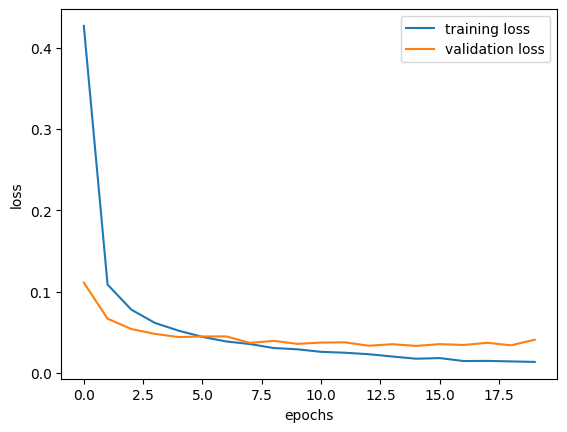

In [6]:
import datetime

net.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

history = net.fit(train_ds, validation_data=val_ds, epochs=20)

import matplotlib.pyplot as plt
plt.figure()
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [8]:
(x_train, y_train), (x_test, y_test) = pp.load_data(return_eval=True)

net.evaluate(x_train, y_train), net.evaluate(x_test, y_test)

313/313 [==============================] - 0s 1ms/step - loss: 0.0293 - accuracy: 0.9919


([0.013093807734549046, 0.9964333176612854],
 [0.02928391471505165, 0.9919000267982483])

In [9]:
net.evaluate(train_aug.batch(512)), net.evaluate(test_aug.batch(512))

118/118 [==============================] - 1s 10ms/step - loss: 0.8981 - accuracy: 0.7975


([0.8963393568992615, 0.7979888916015625],
 [0.8981232047080994, 0.7975000143051147])

In [11]:
train_ext, test_ext = pp.load_ext_data(512, shuffle=False)

net.evaluate(train_ext), net.evaluate(test_ext)

Found 40000 files belonging to 10 classes.
Cause: could not parse the source code of <function load_ext_data.<locals>.<lambda> at 0x7f669fc81670>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function load_ext_data.<locals>.<lambda> at 0x7f669fc81670>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Found 10000 files belonging to 10 classes.
Cause: could not parse the source code of <function load_ext_data.<locals>.<lambda> at 0x7f669fcbbf70>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function load_ext_data.<locals>.<lambda> at 0x7f669fcbbf70>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
 5/79 [>..........................

KeyboardInterrupt: 